# Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

import os
import numpy as np
from glob import glob
import glob
import random
import imageio
from torchvision import transforms
from collections import defaultdict

import segmentation_models_pytorch as smp

# Import Dataset
- Import folder with images
- Import folder with masks
- Create list with training and testing data

In [2]:
# get all the image and mask path and number of images
folder_data_train = glob.glob("datasets/solar_panel/split2/train/amostras/*tiff")
folder_mask_train = glob.glob("datasets/solar_panel/split2/train/labels/*tiff")

folder_data_val = glob.glob("datasets/solar_panel/split2/val/amostras/*tiff")
folder_mask_val = glob.glob("datasets/solar_panel/split2/val/labels/*tiff")

folder_data_test = glob.glob("datasets/solar_panel/split2/test/amostras/*tiff")
folder_mask_test = glob.glob("datasets/solar_panel/split2/test/labels/*tiff")

train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]

# Custom Dataset

In [3]:
class CustomDataset(data.Dataset):
    def __init__(self, image_paths, target_paths, transform=None, transform_label=None):

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transform = transform
        self.transform_label = transform_label
        
    def __getitem__(self, index):

        image = imageio.imread(self.image_paths[index])
        image = np.asarray(image, dtype='float32')
        #print(image.shape)
        
        mask = imageio.imread(self.target_paths[index])
        mask = np.asarray(mask, dtype='int64')
        mask = np.where(mask>1, 0, mask) # some images has soil annotations as well
        
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        
        if self.transform is not None:
            image = self.transform(image)
            
        random.seed(seed)
        torch.manual_seed(seed)
        if self.transform_label is not None:
            mask = self.transform(mask)
            mask = mask.squeeze(0)
        
        return image, mask

    def __len__(self):

        return len(self.image_paths)
    
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()
                               ])


train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=transform, transform_label=transform)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=transforms.ToTensor(), transform_label=None)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transforms.ToTensor(), transform_label=None)

In [4]:
image_datasets = {
    'train': train_dataset, 'val': val_dataset, 'test': test_dataset
}

dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
}

# Import Model

In [5]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

model = smp.Unet(
    in_channels = 4,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    #decoder_atrous_rates = (6, 12, 24) # for DeepLabv3+
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Loss & Optimizer

In [6]:
loss = smp.utils.losses.DiceLoss(eps=1)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5) #, ignore_channels=[False, True, False, False]),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])

In [7]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

test_epoch = smp.utils.train.TestEpoch(
    model,
    loss=loss,
    metrics = metrics,
    device=DEVICE,
    verbose=True)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=40, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=30, shuffle=False, num_workers=0)

In [ ]:
max_score = 10
for i in range(0, 300):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    test_logs = test_epoch.run(test_loader)
    
    # do something (save model, change lr, etc.)
    if max_score > valid_logs['dice_loss']:
        max_score = valid_logs['dice_loss']
        torch.save(model, 'datasets/solar_panel/models_new/unet_effb7.pth')
        print('Model saved!')

# LOAD MODEL

In [9]:
#DLV3
#model = torch.load('datasets/solar_panel/models_new/test.pth')
#model = torch.load('datasets/solar_panel/models_new/dlv3_effb0.pth')
#model = torch.load('datasets/solar_panel/models_new/dlv3_r101.pth')
#model = torch.load('datasets/solar_panel/models_new/dlv3_r50.pth')

# UNET
#model = torch.load('datasets/solar_panel/models_new/unet_r101.pth')
#model = torch.load('datasets/solar_panel/models_new/unet_effb0.pth')
model = torch.load('datasets/solar_panel/models_new/unet_effb7.pth')
#model = torch.load('datasets/solar_panel/models_new/unet_r50.pth')

#PSPNet
#model = torch.load('datasets/solar_panel/models_new/psp_effb7_at.pth')
#model = torch.load('datasets/solar_panel/models_new/psp_effb0.pth')
#model = torch.load('datasets/solar_panel/models_new/psp_r101.pth')
#model = torch.load('datasets/solar_panel/models_new/psp_r50.pth')

# FPN
#model = torch.load('datasets/solar_panel/models_new/fpn_effb7.pth')
#model = torch.load('datasets/solar_panel/models_new/fpn_effb0.pth')
#model = torch.load('datasets/solar_panel/models_new/fpn_r101.pth')
#model = torch.load('datasets/solar_panel/models_new/fpn_r50.pth')

# EVAL MODEL

In [10]:
import math
with torch.no_grad():
    model.eval()

    inp, lab = next(iter(test_loader))

    inp = inp.to(DEVICE)
    lab = lab.to(DEVICE)

    # Predict
    pred = model(inp)

# Accuracy, IoU, and F-score

In [11]:
lbl = lab.cpu().numpy().reshape(-1)
target = pred.data.cpu().numpy().reshape(-1)
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, jaccard_score, accuracy_score
def compute_metrics(label, target):
    acc_50 = accuracy_score(label, np.where(target>0.5, 1, 0))
    acc_75 = accuracy_score(label, np.where(target>0.75, 1, 0))
    
    iou_50 = jaccard_score(label, np.where(target>0.5, 1, 0))
    iou_75 = jaccard_score(label, np.where(target>0.75, 1, 0))
    
    f_50 = f1_score(label, np.where(target>0.5,1,0))
    f_75 = f1_score(label, np.where(target>0.75,1,0))
    
    print('Accuracy', round(acc_50*100, 2), '| ', round(acc_75*100, 2))
    print('IoU', round(iou_50*100, 2), '| ', round(iou_75*100,2))
    print('F-score', round(f_50*100, 2), '| ', round(f_75*100, 2))
    
compute_metrics(lbl, target)

Accuracy 98.08 |  98.07
IoU 91.17 |  91.11
F-score 95.38 |  95.35


# SHOW PREDICTIONS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:1 | IoU: 0.866


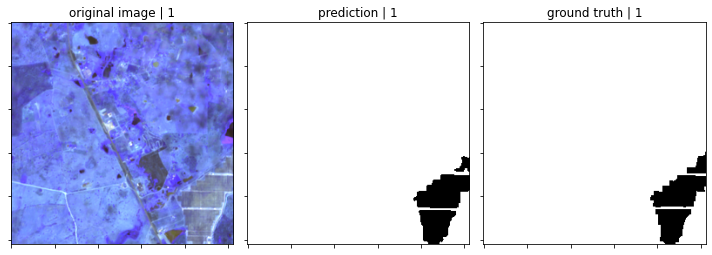

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:2 | IoU: 0.68


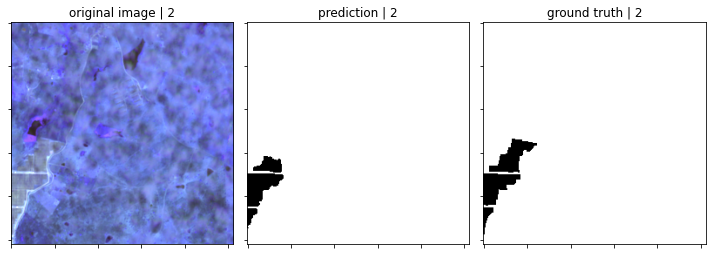

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:3 | IoU: 0.891


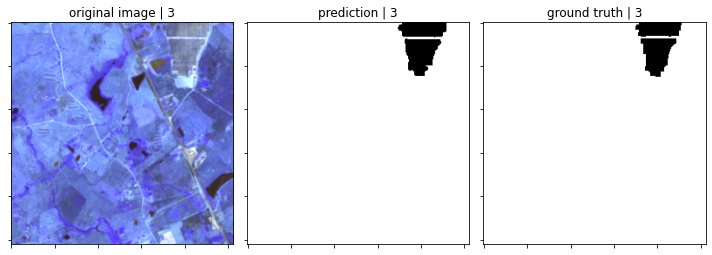

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:4 | IoU: 0.809


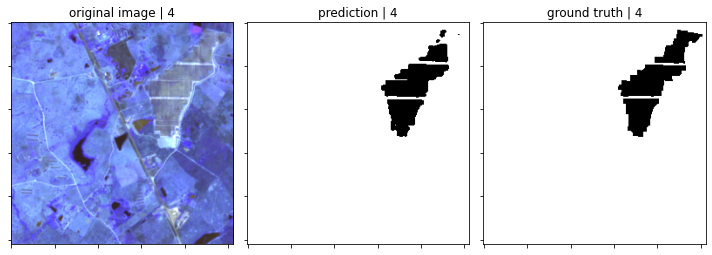

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:5 | IoU: 0.782


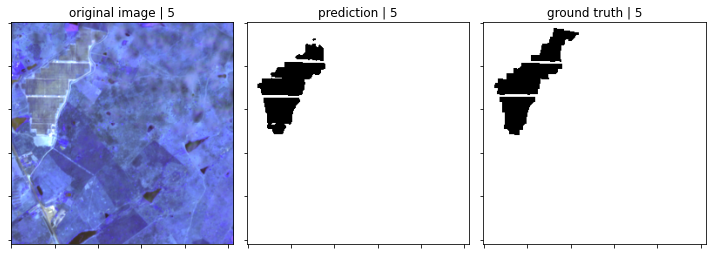

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:6 | IoU: 0.78


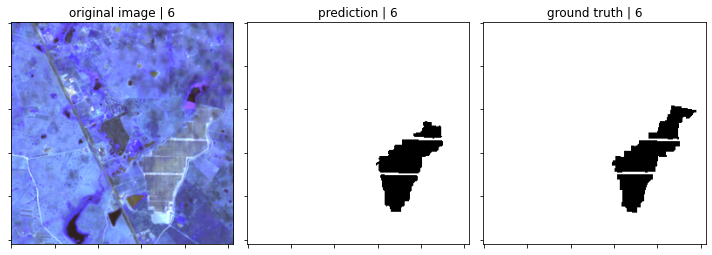

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:7 | IoU: 0.773


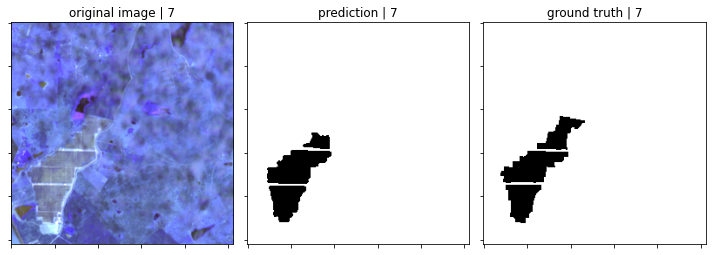

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:8 | IoU: 0.77


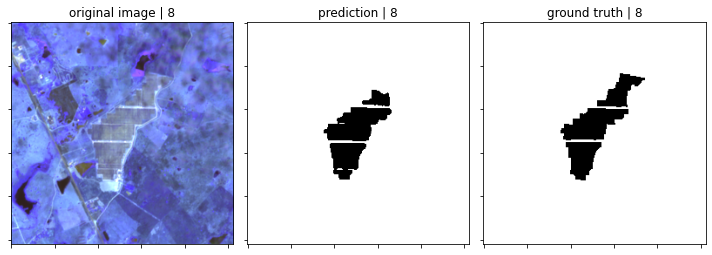

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:9 | IoU: 0.882


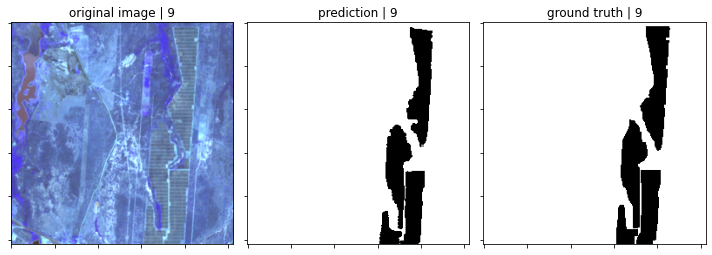

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:10 | IoU: 0.91


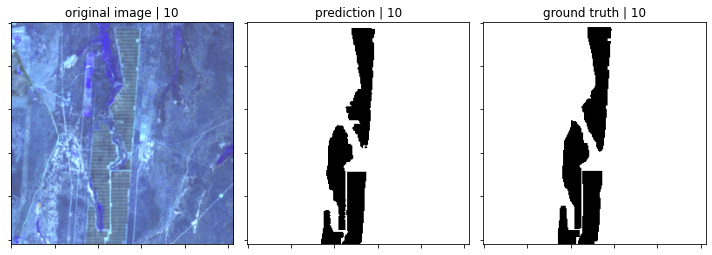

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:11 | IoU: 0.891


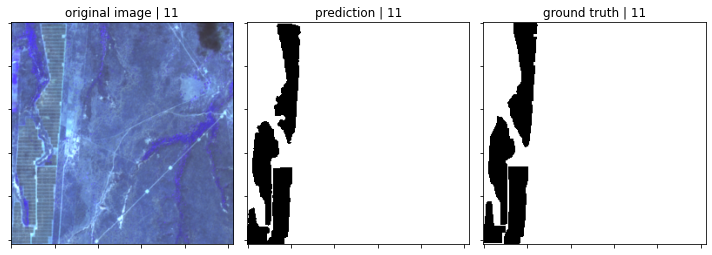

C:\Users\Adm\Anaconda3\envs\detectron2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:12 | IoU: 0.0


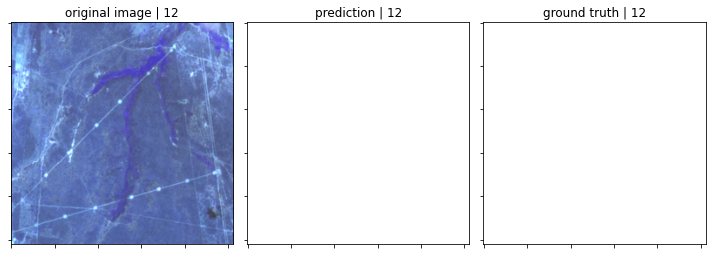

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:13 | IoU: 0.898


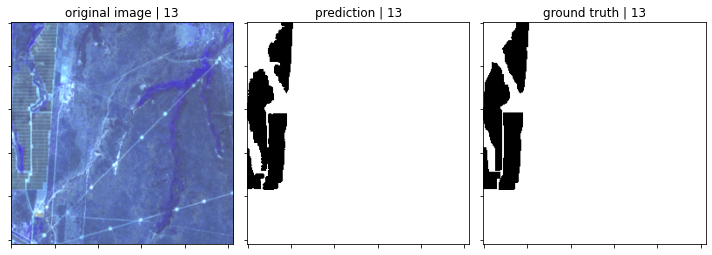

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:14 | IoU: 0.881


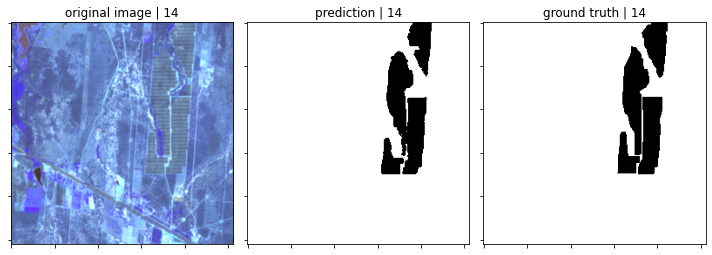

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:15 | IoU: 0.0


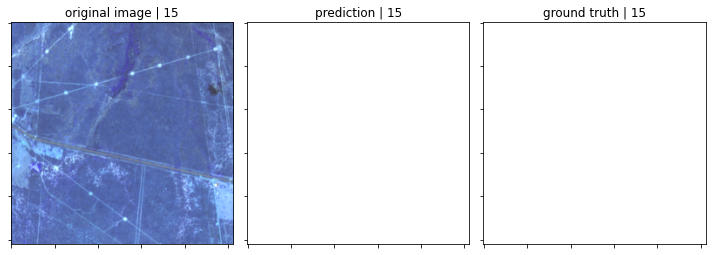

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:16 | IoU: 0.901


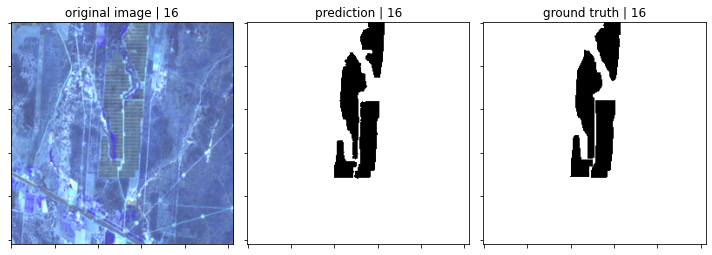

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:17 | IoU: 0.919


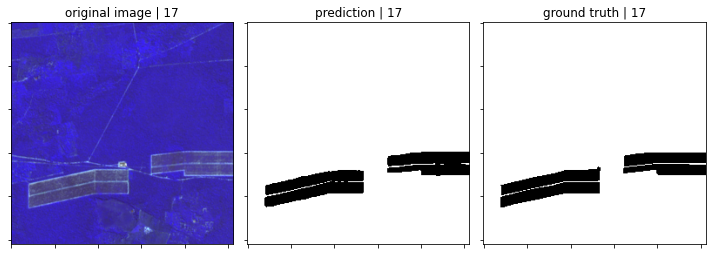

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:18 | IoU: 0.924


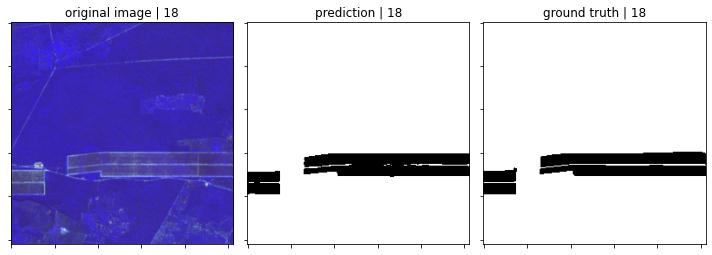

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:19 | IoU: 0.915


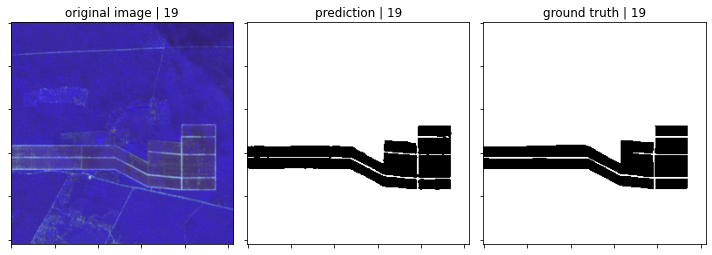

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:20 | IoU: 0.932


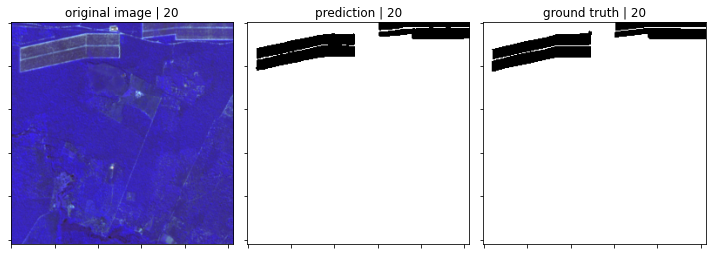

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:21 | IoU: 0.902


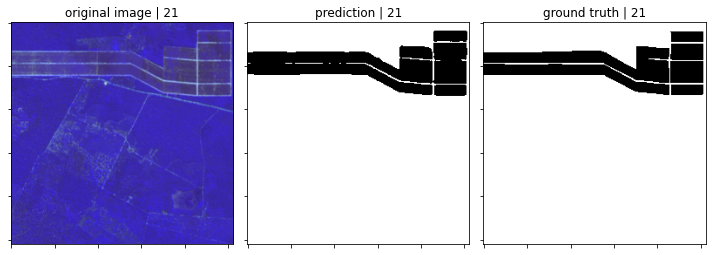

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:22 | IoU: 0.904


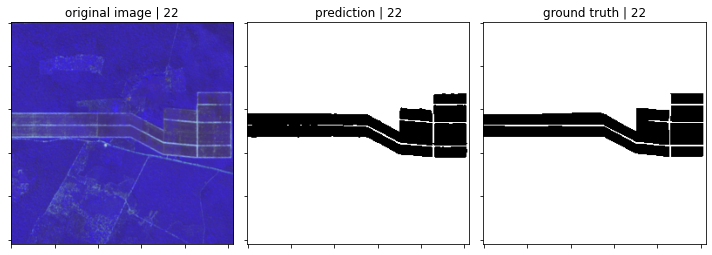

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:23 | IoU: 0.932


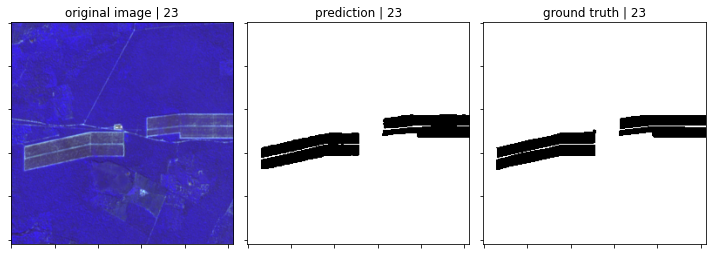

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:24 | IoU: 0.0


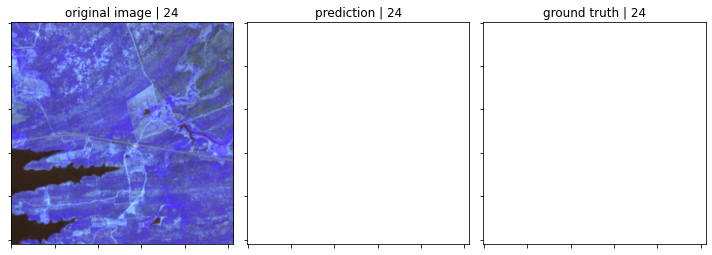

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:25 | IoU: 0.9


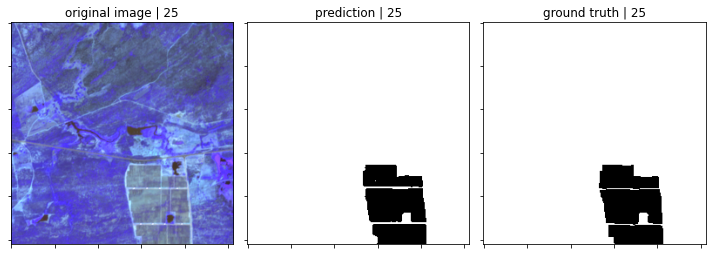

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:26 | IoU: 0.9


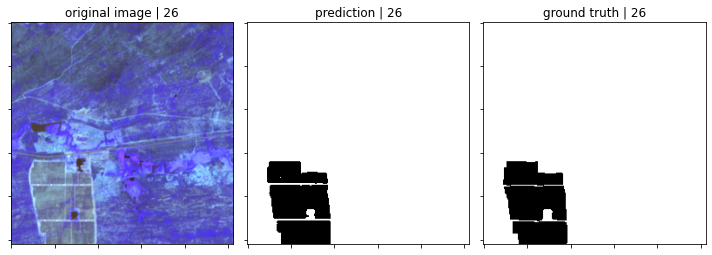

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:27 | IoU: 0.895


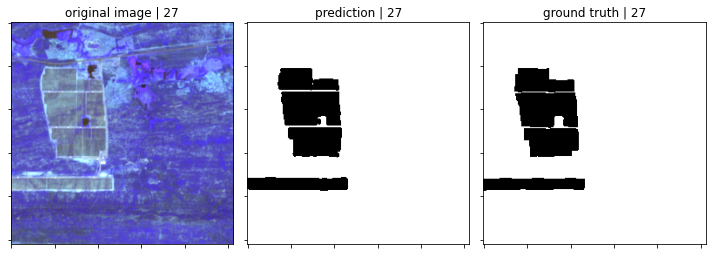

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:28 | IoU: 0.914


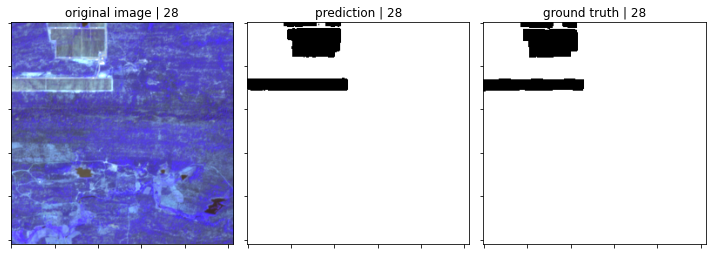

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:29 | IoU: 0.915


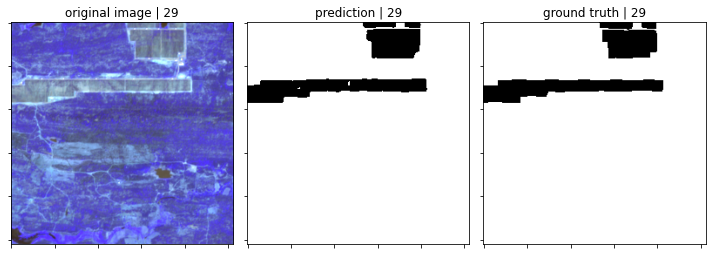

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:30 | IoU: 0.895


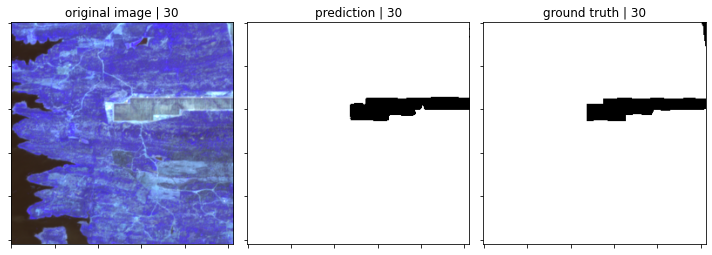

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:31 | IoU: 0.92


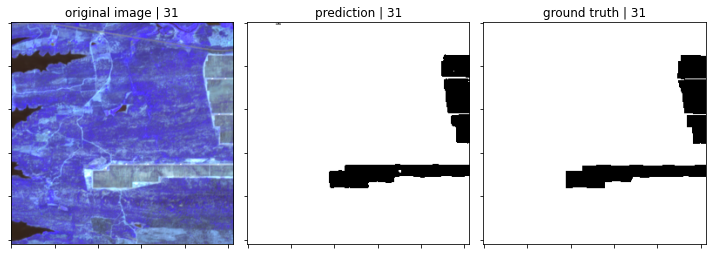

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:32 | IoU: 0.906


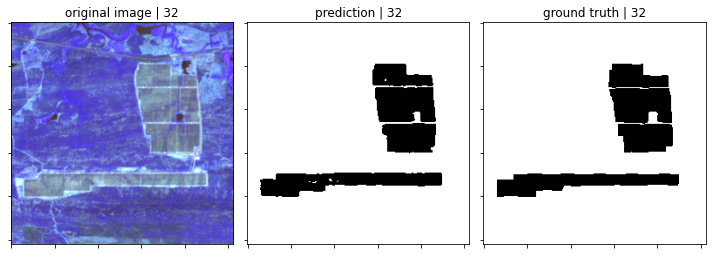

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:33 | IoU: 0.954


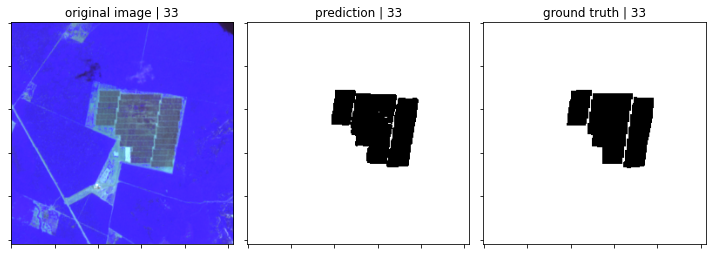

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:34 | IoU: 0.952


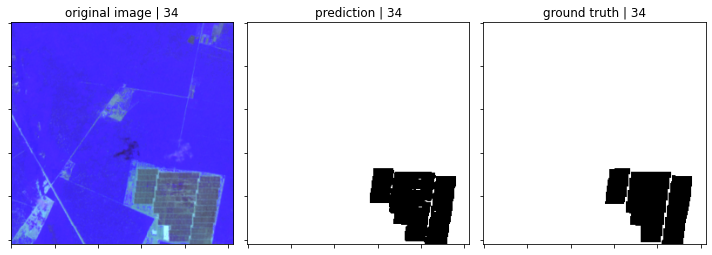

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:35 | IoU: 0.935


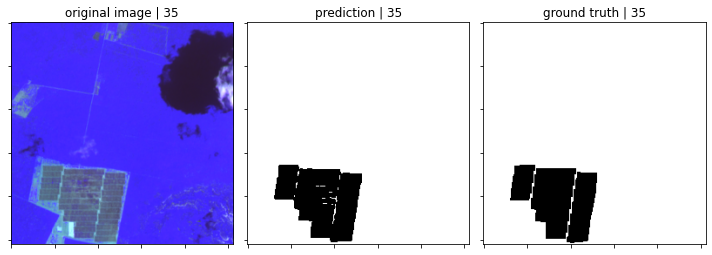

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:36 | IoU: 0.951


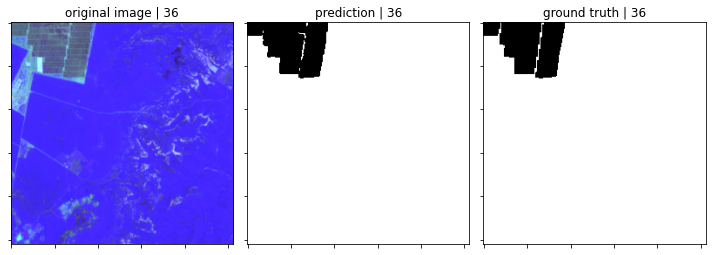

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:37 | IoU: 0.952


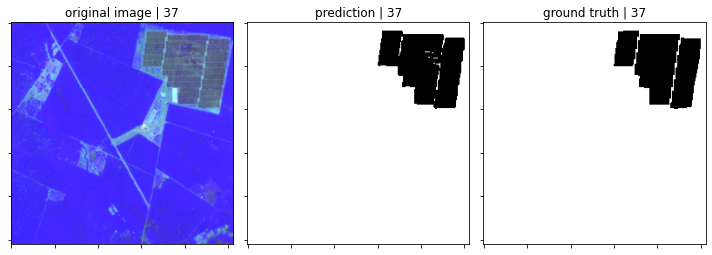

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:38 | IoU: 0.951


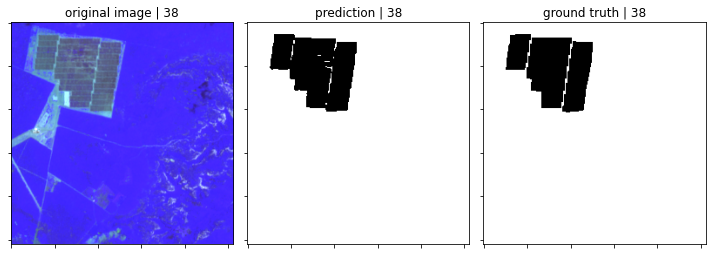

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:39 | IoU: 0.951


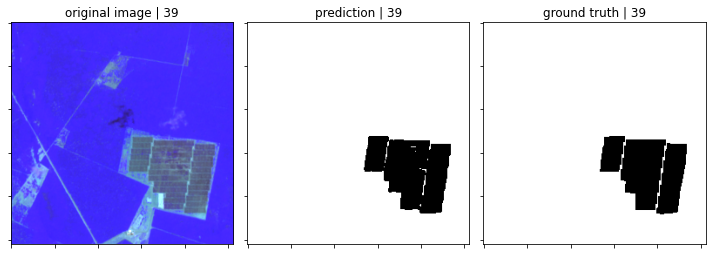

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ID:40 | IoU: 0.94


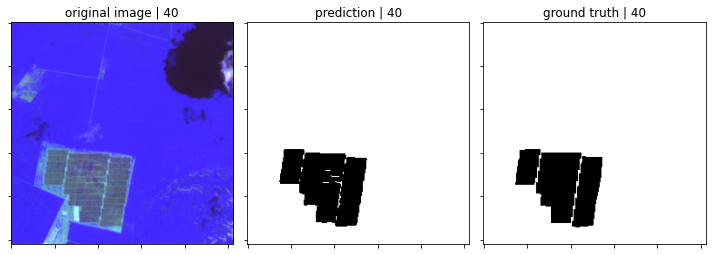

In [12]:
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

actual_img_count = 0
with torch.no_grad():
    
    for data in valid_loader:

        inp, lab = data

        inp = inp.to(DEVICE)
        lab = lab.to(DEVICE)
        pred = model(inp)

        for i in range(0, 40):
            iou_score=0
            
            lab_unit = lab[i,:,:].cpu().numpy()
            inp_unit = inp[i,:,:,:].cpu().numpy() #.reshape(512,512)
            inp_unit = np.transpose(inp_unit, (1, 2, 0))
            
            
            pred_img = pred[i,:,:].data.cpu().numpy().reshape(256,256)
            pred_img = np.where(pred_img>0.5, 1, 0)

            iou_score = jaccard_score(lab_unit.reshape(-1), np.where(pred_img.reshape(-1)>0.5, 1, 0))

            NUM_ROWS = 1
            IMGs_IN_ROW = 3
            f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(10,10))

            ax[0].imshow(inp_unit[:,:,1:4]/3000)
            ax[1].imshow(pred_img, cmap='binary')
            ax[2].imshow(lab_unit, cmap='binary')

            ax[0].set_title('original image | '+str(actual_img_count+1))
            ax[1].set_title('prediction | '+str(actual_img_count+1))
            ax[2].set_title('ground truth | '+str(actual_img_count+1))

            ax[0].set_yticklabels([])
            ax[0].set_xticklabels([])

            ax[1].set_yticklabels([])
            ax[1].set_xticklabels([])

            ax[2].set_yticklabels([])
            ax[2].set_xticklabels([])

            print('ID:'+str(actual_img_count+1)+' | IoU: ' + str(round(iou_score, 3)))
            plt.tight_layout()
            
            if (actual_img_count == 15) or (actual_img_count == 22) or (actual_img_count == 29):
                plt.savefig('imgs/img'+str(actual_img_count)+'.png', dpi=500, bbox_inches='tight', pad_inches=0)
            plt.show()
            
            actual_img_count+=1

# MOSAICKING

In [13]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
img_path = 'F:/solar/mosaic/BJ_img_1536x768.tif'
lbl_path = 'F:/solar/mosaic/BJ_mask_1536x768.tif'

def mosaicking(img_path, stride, window, model):
    image = imageio.imread(img_path).astype('float32') # read image
    image = image.reshape(1, 4, 768, 1536) # formato (1, C, H, W)

    print(image.shape)
    image = torch.from_numpy(image) # passar para tensor para ler a imagem
    #print(image.shape) # (1, C, H, W)
    
    width = image.shape[2]
    height = image.shape[3]

    new_height = int((height-window)/stride)*stride 
    new_width = int((width-window)/stride)*stride

    img_width = new_width+window
    img_height = new_height+window

    img_final = np.zeros((768, 1536), dtype="float32")
    contador_final = np.zeros((768, 1536), dtype='float32')
    
    model.eval()
    
    for row in tqdm(range(0,new_width+1, stride)):
        for col in range(0,new_height+1, stride):

            actual_img = image[:, :, row:row+window, col:col+window].to(DEVICE).float()
            actual_pred = model(actual_img)
            actual_pred = actual_pred.data.cpu().numpy()
            actual_pred = actual_pred.reshape(window,window)

            for pjlin in range(0, window):
                p1 = row + pjlin
                for pjcol in range(0, window):
                    p2 = col + pjcol   
                    value = actual_pred[pjlin, pjcol]
                    img_final[p1,p2] += value
                    contador_final[p1,p2] += 1
    
    classified_image = img_final/contador_final
    classified_image = np.nan_to_num(classified_image)
    return classified_image

def mosaick_metrics(clf_img, lbl_path):
    clf_img = np.nan_to_num(clf_img)
    clf_img = clf_img.reshape(-1)
    
    lbl = imageio.imread(lbl_path).astype('int16')
    lbl = np.where(lbl>1, 0, lbl)
    lbl = lbl.reshape(-1)

    roc = roc_auc_score(lbl, clf_img)
    pr = average_precision_score(lbl, clf_img)
    print('ROC:', round(roc*100,2), ' | PR:', round(pr*100, 2))

In [14]:
# Get classifications for different mosaicking strides
clf_8 = mosaicking(img_path, 8, 256, model)
clf_16 = mosaicking(img_path, 16, 256, model)
clf_32 = mosaicking(img_path, 32, 256, model)
clf_64 = mosaicking(img_path, 64, 256, model)
clf_128 = mosaicking(img_path, 128, 256, model)
clf_256 = mosaicking(img_path, 256, 256, model)

# Save classifications in npz files
np.savez('clf_8', x=clf_8)
np.savez('clf_16', x=clf_16)
np.savez('clf_32', x=clf_32)
np.savez('clf_64', x=clf_64)
np.savez('clf_128', x=clf_128)
np.savez('clf_256', x=clf_256)

(1, 4, 768, 1536)



(1, 4, 768, 1536)



(1, 4, 768, 1536)



(1, 4, 768, 1536)



(1, 4, 768, 1536)



(1, 4, 768, 1536)


# Mosaicking metrics

In [15]:
# import label
lbl = imageio.imread(lbl_path).astype('int16')
#lbl = np.where(lbl>1, 0, lbl)

# AP Scores
print("Stride 8 AP:", 100*round(average_precision_score(lbl.reshape(-1), clf_8.reshape(-1)),4))
print("Stride 16 AP:",100*round(average_precision_score(lbl.reshape(-1), clf_16.reshape(-1)),4))
print("Stride 32 AP:",100*round(average_precision_score(lbl.reshape(-1), clf_32.reshape(-1)),4))
print("Stride 64 AP:",100*round(average_precision_score(lbl.reshape(-1), clf_64.reshape(-1)),4))
print("Stride 128 AP:",100*round(average_precision_score(lbl.reshape(-1), clf_128.reshape(-1)),4))
print("Stride 256 AP:",100*round(average_precision_score(lbl.reshape(-1), clf_256.reshape(-1)),4))

# ROC AUC
print("Stride 8 ROC AUC:",100*round(roc_auc_score(lbl.reshape(-1), clf_8.reshape(-1)),4))
print("Stride 16 ROC AUC:",100*round(roc_auc_score(lbl.reshape(-1), clf_16.reshape(-1)),4))
print("Stride 32 ROC AUC:",100*round(roc_auc_score(lbl.reshape(-1), clf_32.reshape(-1)),4))
print("Stride 64 ROC AUC:",100*round(roc_auc_score(lbl.reshape(-1), clf_64.reshape(-1)),4))
print("Stride 128 ROC AUC:",100*round(roc_auc_score(lbl.reshape(-1), clf_128.reshape(-1)),4))
print("Stride 256 ROC AUC:",100*round(roc_auc_score(lbl.reshape(-1), clf_256.reshape(-1)),4))

Stride 8 AP: 97.85000000000001
Stride 16 AP: 97.56
Stride 32 AP: 96.99
Stride 64 AP: 96.41999999999999
Stride 128 AP: 95.39
Stride 256 AP: 94.49
Stride 8 ROC AUC: 99.42
Stride 16 ROC AUC: 99.25
Stride 32 ROC AUC: 98.89
Stride 64 ROC AUC: 98.66
Stride 128 ROC AUC: 98.36
Stride 256 ROC AUC: 98.16


# Original image with 1536x768 spatial dimensions

In [16]:
disp_img = imageio.imread(img_path).astype('float32')
disp_img = np.transpose(disp_img, (1,2,0))
disp_img[:,:,0].max()

# make visualization better
disp_img[:,:,0] = disp_img[:,:,0]/5905
disp_img[:,:,1] = disp_img[:,:,1]/5145
disp_img[:,:,2] = disp_img[:,:,2]/6071
disp_img[:,:,3] = disp_img[:,:,3]/5758

# Show mosaicking predictions

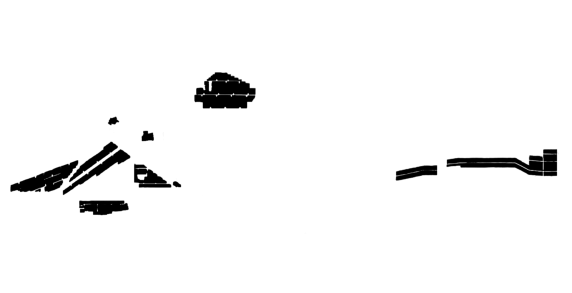

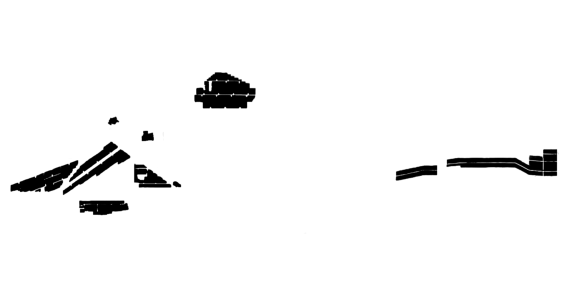

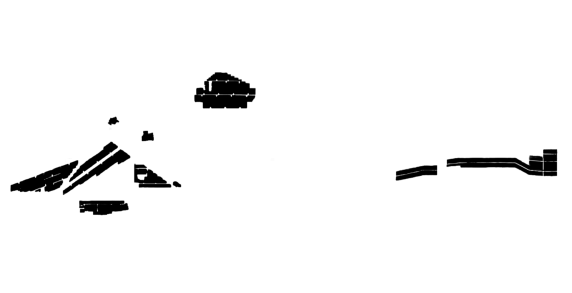

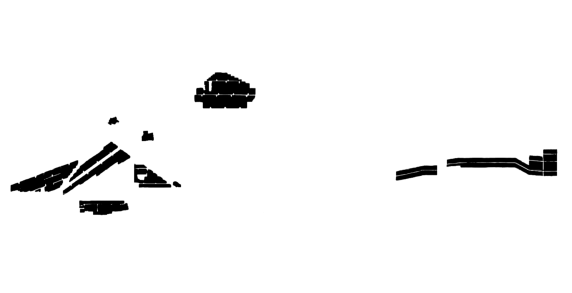

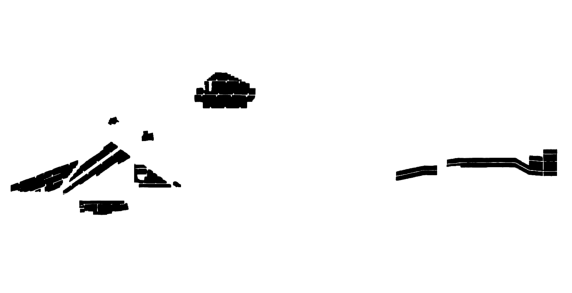

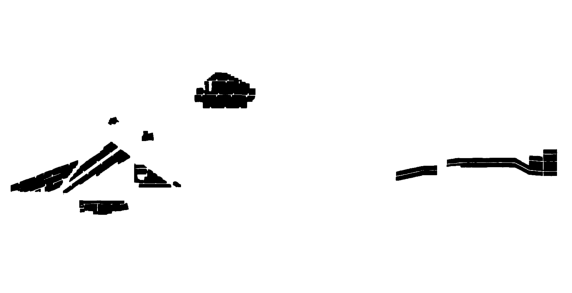

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(clf_8, cmap='binary')
plt.axis('off')
#plt.savefig('pred1536x768.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(clf_16, cmap='binary')
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(clf_32, cmap='binary')
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(clf_64, cmap='binary')
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(clf_128, cmap='binary')
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(clf_256, cmap='binary')
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

# Show prediction using a specific threshold

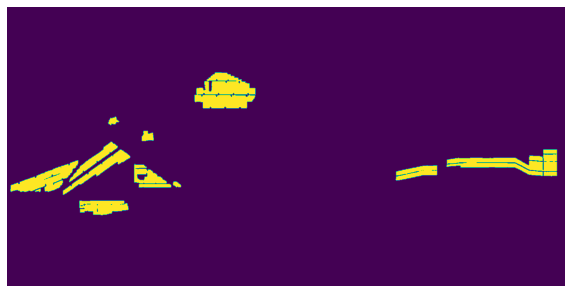

In [19]:
# USING A THRESHOLD
plt.figure(figsize=(10,10))
plt.imshow(np.where(clf_8>0.5,1,0))
plt.axis('off')
#plt.savefig('full.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()